### Plot types of residues' spatial information
### Active vs Nonactive

##### ↓ Extract spatial information

In [1]:
from Bio.PDB import *
import urllib.request
import numpy as np
import pandas as pd
from math import sqrt
import time
import matplotlib.pyplot as plt

In [2]:
cd C:\Users\Administrator\Desktop\temp

C:\Users\Administrator\Desktop\temp


In [3]:
backbone = ["N","CA","C","O"]
aminoAcidCodes = ["ALA","ARG","ASN","ASP","CYS","GLN","GLY","GLU","HIS","ILE","LEU","LYS",
                 "MET","PHE","PRO","SER","THR","TRP","TYR","VAL"]

In [120]:
peptidasesList = pd.read_csv("Y:/Yuan/temp/MCSA_EC3.4_peptidases.csv")
peptidasesList = peptidasesList[peptidasesList.iloc[:,4] == "residue"]
peptidasesList = peptidasesList.reset_index(drop=True)
bindingSiteDic = {}
for i in range(len(peptidasesList)):
    #print(bindingSiteDic)
    if peptidasesList.loc[i,"PDB"] not in bindingSiteDic:
        bindingSiteDic[peptidasesList.loc[i,"PDB"]] = {peptidasesList.loc[i,"chain/kegg compound"]: [peptidasesList.loc[i,"resid/chebi id"]]}
    elif peptidasesList.loc[i,"chain/kegg compound"] not in bindingSiteDic[peptidasesList.loc[i,"PDB"]]:
         bindingSiteDic[peptidasesList.loc[i,"PDB"]] = {peptidasesList.loc[i,"chain/kegg compound"]: [peptidasesList.loc[i,"resid/chebi id"]]}
    else:
        bindingSiteDic[peptidasesList.loc[i,"PDB"]][peptidasesList.loc[i,"chain/kegg compound"]].append(peptidasesList.loc[i,"resid/chebi id"])
for protein in bindingSiteDic:
    for chain in bindingSiteDic[protein]:
        bindingSiteDic[protein][chain] = list(set(bindingSiteDic[protein][chain])) 

uniqueList = peptidasesList[["PDB","chain/kegg compound"]].drop_duplicates()

In [113]:
uniqueList

,PDB,chain/kegg compound
0,1lam,A
2,1lok,A
25,1xgm,A
30,1b65,A
36,1ei5,A
42,1azw,A
49,1a16,A
64,1itq,A
92,1fy2,A
97,1r44,A


In [5]:
bindingSiteDic["2bhg"]

{'A': [163.0, 84.0, 182.0, 46.0]}

In [270]:
pdbID = "1rtf"
chainOrder = "B"
PDB = PDBList()
PDB.retrieve_pdb_file(pdb_code = pdbID, pdir = "Y:/Yuan/temp", file_format="pdb")

Structure exists: 'Y:/Yuan/temp\pdb1rtf.ent' 


'Y:/Yuan/temp\\pdb1rtf.ent'

In [342]:
p = PDBParser()
structure = p.get_structure("X","Y:/Yuan/temp/pdb"+pdbID+".ent")

C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2853.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2865.
  PDBConstructionWarning)


In [346]:
oneChain = pd.DataFrame(columns = ["Seq","Residue","Center","Direction"])
if structure.header["resolution"]<=3.0:
    if chainOrder in [x.id for x in list(structure[0].get_chains())]: #Chain information not in pdb file
        for residue in structure[0][chainOrder]: 
            if residue.get_resname() in aminoAcidCodes: # Only treat common amino acid
                if residue.get_id()[2] == " ": #ignore insetions
                    if len(list(residue.get_atoms())) >3:
                        if residue.get_resname() != "GLY":  # Glysine as a special case
                            point = vectors.Vector([0,0,0])
                            for atom in residue:
                                if(atom.get_name() not in backbone):
                                    point = point + atom.get_vector()
                            center = point.__div__(len(residue)-4)
                            cToRGroup = residue["CA"].get_vector()-center
                            oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]        
                        else:
                            center = residue["CA"].get_vector()
                            cToRGroup = center - (residue["C"].get_vector()+residue["N"].get_vector()+residue["O"].get_vector()).__div__(3)
                            oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]


In [347]:
distanceMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
angleMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
numResidue = len(oneChain)
for row in range(0,numResidue):
    if row % 50 ==0:
        print(str(row)+"th row")
    for column in range(0,numResidue):
        coordinatesSubstraction = list(oneChain.loc[row,"Center"] - oneChain.loc[column,"Center"])
        distanceMatrix.iloc[row,column] = sqrt(sum(list(map(lambda x:x*x, coordinatesSubstraction))))
        v1 = oneChain.loc[row,"Direction"] 
        v2 = oneChain.loc[column,"Direction"]
        angleMatrix.iloc[row,column] = 180*np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))/np.pi

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


50th row
100th row
150th row
200th row


In [351]:
allTwoResidue = oneChain[(oneChain["Residue"] == residue1)|(oneChain["Residue"] == residue2)]
allTwoResidue.is_copy = False
allTwoResidue.loc[:,"active"] = np.where(allTwoResidue["Seq"].isin(bindingSiteDic[pdbID][chainOrder]),"yes","no")
allTwoResidue["all_point"] = None
allTwoResidue["PDBID"] = pdbID
allTwoResidue["Chain"] = chainOrder
rawAllTwoResidue=allTwoResidue.copy(deep=True)
for i,row in allTwoResidue.iterrows():
    if row["Residue"] == residue1:
        allPoint = list()
        oneResidue1 = row["Seq"]
        for oneResidue2 in rawAllTwoResidue[rawAllTwoResidue["Residue"]==residue2]["Seq"]:
            coordinate1=distanceMatrix.loc[oneResidue1,oneResidue2]
            coordinate2=angleMatrix.loc[oneResidue1,oneResidue2]      
            allPoint.append(str(coordinate1))
            allPoint.append(str(coordinate2))
            print("Coordinate1--{}--oneResidue1~{}: {}".format(i,oneResidue1,coordinate1))
            print("Coordinate2--{}--oneResidue2~{}: {}".format(i,oneResidue2,coordinate2))
        allTwoResidue.set_value(i,"all_point",",".join(allPoint))

Coordinate1--10--oneResidue1~26: 5.196218509634063
Coordinate2--10--oneResidue2~23: 35.32900729487216
Coordinate1--10--oneResidue1~26: 34.91793423055205
Coordinate2--10--oneResidue2~95: 92.71462170180487
Coordinate1--10--oneResidue1~26: 34.408914315337206
Coordinate2--10--oneResidue2~96: 124.32727516953689
Coordinate1--10--oneResidue1~26: 36.98529869952101
Coordinate2--10--oneResidue2~97: 128.39542689121677
Coordinate1--10--oneResidue1~26: 32.17497840862682
Coordinate2--10--oneResidue2~100: 140.05475376054298
Coordinate1--10--oneResidue1~26: 25.99754007104386
Coordinate2--10--oneResidue2~102: 21.098185542541597
Coordinate1--10--oneResidue1~26: 28.389142303671555
Coordinate2--10--oneResidue2~127: 111.68269697311732
Coordinate1--10--oneResidue1~26: 27.334110260223202
Coordinate2--10--oneResidue2~132: 124.44570361009139
Coordinate1--10--oneResidue1~26: 32.22056733629829
Coordinate2--10--oneResidue2~178: 136.89677910761463
Coordinate1--10--oneResidue1~26: 19.885510381929695
Coordinate2--10

In [341]:
structure[0]["B"][110].get_id()[2]==" "

True

In [317]:
oneChain.iloc[100:,]

,Seq,Residue,Center,Direction
100,110,ASP,"<Vector 15.83, 3.95, 43.16>","<Vector -0.01, 1.14, 1.90>"
101,110,SER,"<Vector 18.68, 7.30, 42.80>","<Vector 0.00, 0.30, 1.82>"
102,110,SER,"<Vector 20.85, 11.45, 45.34>","<Vector -1.59, -0.09, -1.07>"
103,110,ARG,"<Vector 21.85, 12.32, 38.80>","<Vector -3.67, -1.23, 1.79>"
104,111,CYS,"<Vector 14.54, 11.85, 40.69>","<Vector -0.00, -1.07, -1.10>"
105,112,ALA,"<Vector 13.22, 12.92, 36.89>","<Vector 0.25, -1.03, -0.78>"
106,113,GLN,"<Vector 16.57, 7.93, 33.63>","<Vector -0.73, 3.11, -0.35>"
107,114,GLU,"<Vector 18.24, 14.80, 29.31>","<Vector -1.89, -1.66, 0.88>"
108,115,SER,"<Vector 13.35, 11.74, 27.80>","<Vector 1.53, 0.28, -0.86>"
109,116,SER,"<Vector 12.78, 12.08, 22.94>","<Vector 0.49, 1.63, 1.00>"


In [423]:
#define two residue types for plotting
residue1 = "GLY"
residue2 = "ASP"
resultContainer = list()
for index, oneRow in uniqueList.iterrows():
    try:
        pdbID = oneRow["PDB"]
        chainOrder = oneRow["chain/kegg compound"]
        PDB = PDBList()
        PDB.retrieve_pdb_file(pdb_code = pdbID, pdir = "Y:/Yuan/temp", file_format="pdb")
        p = PDBParser()
        structure = p.get_structure("X","Y:/Yuan/temp/pdb"+pdbID+".ent")
        oneChain = pd.DataFrame(columns = ["Seq","Residue","Center","Direction"])
        if structure.header["resolution"]<=3.0:
            if chainOrder in [x.id for x in list(structure[0].get_chains())]: #Chain information not in pdb file
                for residue in structure[0][chainOrder]: 
                    if residue.get_resname() in aminoAcidCodes: # Only treat common amino acid
                        if residue.get_id()[2] == " ": #ignore insertions
                            if len(list(residue.get_atoms())) >3:
                                if residue.get_resname() != "GLY":  # Glysine as a special case
                                    point = vectors.Vector([0,0,0])
                                    for atom in residue:
                                        if(atom.get_name() not in backbone):
                                            point = point + atom.get_vector()
                                    center = point.__div__(len(residue)-4)
                                    cToRGroup = residue["CA"].get_vector()-center
                                    oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]        
                                else:
                                    center = residue["CA"].get_vector()
                                    cToRGroup = center - (residue["C"].get_vector()+residue["N"].get_vector()+residue["O"].get_vector()).__div__(3)
                                    oneChain.loc[len(oneChain)] = [residue.get_id()[1],residue.get_resname(),center,cToRGroup]
            allTwoResidue = oneChain[(oneChain["Residue"] == residue1)|(oneChain["Residue"] == residue2)]
            allTwoResidue.is_copy = False
            allTwoResidue.loc[:,"active"] = np.where(allTwoResidue["Seq"].isin(bindingSiteDic[pdbID][chainOrder]),"yes","no")
        distanceMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
        angleMatrix = pd.DataFrame(columns = list(oneChain.iloc[:,0]),index = list(oneChain.iloc[:,0]))
        numResidue = len(oneChain)
        for row in range(0,numResidue):
            if row % 50 ==0:
                print(str(row)+"th row")
            for column in range(0,numResidue):
                coordinatesSubstraction = list(oneChain.loc[row,"Center"] - oneChain.loc[column,"Center"])
                distanceMatrix.iloc[row,column] = sqrt(sum(list(map(lambda x:x*x, coordinatesSubstraction))))
                v1 = oneChain.loc[row,"Direction"] 
                v2 = oneChain.loc[column,"Direction"]
                angleMatrix.iloc[row,column] = 180*np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))/np.pi
        allTwoResidue["all_point"] = None
        allTwoResidue["PDBID"] = pdbID
        allTwoResidue["Chain"] = chainOrder
        rawAllTwoResidue=allTwoResidue.copy(deep=True)
        for i,row in allTwoResidue.iterrows():
            if row["Residue"] == residue1:
                allPoint = list()
                oneResidue1 = row["Seq"]
                for oneResidue2 in rawAllTwoResidue[rawAllTwoResidue["Residue"]==residue2]["Seq"]:
                    coordinate1=distanceMatrix.loc[oneResidue1,oneResidue2]
                    coordinate2=angleMatrix.loc[oneResidue1,oneResidue2]      
                    allPoint.append(str(coordinate1))
                    allPoint.append(str(coordinate2))
                allTwoResidue.set_value(i,"all_point",",".join(allPoint))
        resultContainer.append(allTwoResidue)
    except Exception:
        print(pdbID,"skipped")
combinedResult = pd.concat(resultContainer)

Structure exists: 'Y:/Yuan/temp\pdb1lam.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
Structure exists: 'Y:/Yuan/temp\pdb1lok.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1xgm.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5132.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5134.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5136.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5141.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1b65.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17416.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17636.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17856.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 18086.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 18302.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
Structure exists: 'Y:/Yuan/temp\pdb1ei5.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\vectors.py:273: RuntimeWarning: invalid value encountered in true_divide
  a = self._ar / numpy.array(x)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
Structure exists: 'Y:/Yuan/temp\pdb1azw.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5519.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5610.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
Structure exists: 'Y:/Yuan/temp\pdb1a16.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
Structure exists: 'Y:/Yuan/temp\pdb1itq.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6343.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6373.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6403.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6516.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
Structure exists: 'Y:/Yuan/temp\pdb1fy2.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1r44.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10667.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10668.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10669.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10670.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10671.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1pfq.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12693.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12721.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12749.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13017.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
700th row
Structure exists: 'Y:/Yuan/temp\pdb1whs.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3750.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3812.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3844.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4075.
  PDBConstructionWarning)


1whs skipped
Structure exists: 'Y:/Yuan/temp\pdb1whs.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3750.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3812.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3844.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4075.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\vectors.py:273: RuntimeWarning: invalid value encountered in true_divide
  a = self._ar / numpy.array(x)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
Structure exists: 'Y:/Yuan/temp\pdb1m4l.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
Structure exists: 'Y:/Yuan/temp\pdb1cg2.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12097.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12101.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12104.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12107.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12110.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
Structure exists: 'Y:/Yuan/temp\pdb1lbu.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1deu.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4763.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4985.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1uch.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1nbf.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10274.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10416.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10555.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10586.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10608.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
Structure exists: 'Y:/Yuan/temp\pdb2bx4.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1aug.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8378.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8460.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8543.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8630.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1onw.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6400.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6412.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6421.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6763.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
Structure exists: 'Y:/Yuan/temp\pdb1l9x.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10287.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10291.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10299.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10307.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10311.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1k32.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 50895.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 51296.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 51691.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 52089.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 52490.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
700th row
750th row
800th row
850th row
900th row
950th row
1000th row
Structure exists: 'Y:/Yuan/temp\pdb1yph.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7786.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7796.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7806.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 7826.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7836.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\en

1yph skipped
Structure exists: 'Y:/Yuan/temp\pdb1yph.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7796.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7806.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 7826.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7836.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7870.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\en

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
Structure exists: 'Y:/Yuan/temp\pdb1nlu.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6007.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6884.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6886.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
Structure exists: 'Y:/Yuan/temp\pdb1ssx.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1qfm.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
700th row
Structure exists: 'Y:/Yuan/temp\pdb1pq5.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1hzf.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1s01.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1rtf.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2853.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2865.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1qrz.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8185.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8304.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8438.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 8602.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1ds2.ent' 
Structure exists: 'Y:/Yuan/temp\pdb1jhf.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 2036.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 2148.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2875.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2993.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1t7d.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4235.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4238.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4241.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4363.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4498.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\en

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1tyf.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 20964.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21053.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 21142.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 21236.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 21325.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1wpo.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3859.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3972.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1rgq.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3416.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3417.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1g2i.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4432.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4437.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4525.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4636.
  PDBConstructionWarning)


1g2i skipped
Structure exists: 'Y:/Yuan/temp\pdb1g2i.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4432.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4437.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4525.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4636.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1dki.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10724.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10729.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10734.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10739.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10744.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb8pch.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2549.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 3159.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb9pap.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1glo.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1cqq.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb2bhg.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3370.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3424.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1x9y.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11847.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11915.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11973.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12022.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
Structure exists: 'Y:/Yuan/temp\pdb2fqq.ent' 
2fqq skipped
Structure exists: 'Y:/Yuan/temp\pdb2fqq.ent' 
2fqq skipped
Structure exists: 'Y:/Yuan/temp\pdb1cvr.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2361.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2368.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2361.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2368.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
Structure exists: 'Y:/Yuan/temp\pdb1nln.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2183.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2406.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1gcb.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
Structure exists: 'Y:/Yuan/temp\pdb1kfu.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 7800.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain S is discontinuous at line 8087.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
Structure exists: 'Y:/Yuan/temp\pdb1qx3.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1qtn.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2429.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2439.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2449.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2656.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2763.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1nw9.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3087.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb2bkr.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2755.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2903.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1am5.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
Structure exists: 'Y:/Yuan/temp\pdb1a30.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1886.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1992.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2099.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
Structure exists: 'Y:/Yuan/temp\pdb1a30.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1886.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1992.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2099.
  PDBConstructionWarning)


1a30 skipped
Structure exists: 'Y:/Yuan/temp\pdb1s2k.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1889.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2022.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1i78.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5121.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5177.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5217.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5236.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
Structure exists: 'Y:/Yuan/temp\pdb1r1j.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
Structure exists: 'Y:/Yuan/temp\pdb1i1i.ent' 
Structure exists: 'Y:/Yuan/temp\pdb1hfs.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1ge7.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2964.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2976.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2988.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3138.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1ast.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1qib.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1kei.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
Structure exists: 'Y:/Yuan/temp\pdb1lml.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
Structure exists: 'Y:/Yuan/temp\pdb1eb6.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
Structure exists: 'Y:/Yuan/temp\pdb1hr6.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 29084.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29099.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 29100.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 29101.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 29102.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
Structure exists: 'Y:/Yuan/temp\pdb1i1e.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
700th row
750th row
800th row
850th row
900th row
950th row
1000th row
1050th row
1100th row
1150th row
1200th row
1250th row
Structure exists: 'Y:/Yuan/temp\pdb1pwv.ent' 
0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row
450th row
500th row
550th row
600th row
650th row
700th row
Structure exists: 'Y:/Yuan/temp\pdb1ryp.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 51464.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 51466.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 51467.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 51468.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 51469.
  PDBConstructionWarning)
C:\Users\Administrator\Anacond

0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
Structure exists: 'Y:/Yuan/temp\pdb1ht1.ent' 


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 24864.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 24891.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 24918.
  PDBConstructionWarning)
C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\Bio\PDB\StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 24945.
  PDBConstructionWarning)


0th row


C:\Users\Administrator\Anaconda3\envs\pdbPy3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos


50th row
100th row
150th row
200th row
250th row
300th row
350th row
400th row


In [424]:
combinedResult.to_csv("combineResult.csv")

In [432]:
coordinate1 = list()
coordinate2 = list()
flag = False
for eachRow in combinedResult[(combinedResult["Residue"] != residue2)&(combinedResult["active"]=="yes")]["all_point"]:
    if eachRow != None:
        if len(eachRow.strip().split(","))>1:
            for i,element in enumerate(eachRow.strip().split(",")):
                if i%2 == 0:
                    if float(element) <17:
                        flag = True
                        coordinate1.append(element)
                elif i%2 ==1 & flag:
                    coordinate2.append(element)
                    flag = False

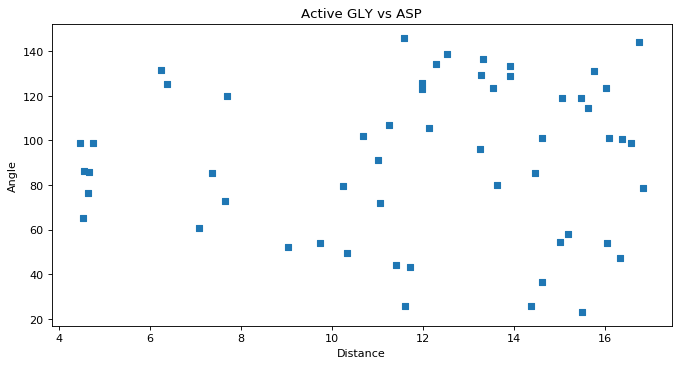

In [433]:
plt.figure(figsize = (10,5),dpi=80)

plt.scatter(coordinate1,coordinate2,
           marker = "s")


#plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])

plt.xlabel("Distance")
plt.ylabel("Angle")

plt.title("Active {} vs {}".format(residue1,residue2))
plt.savefig("Active {} vs {}.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()

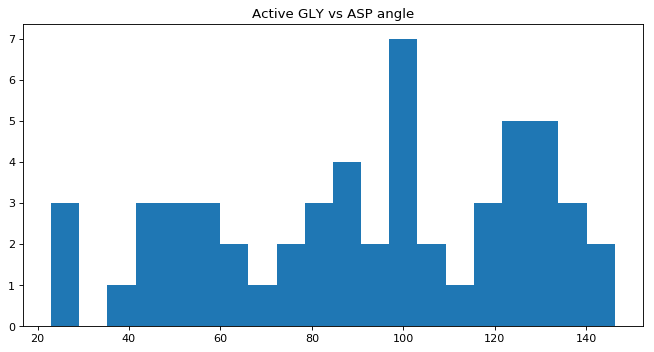

In [434]:
plt.figure(figsize = (10,5),dpi=80)
plt.hist([float(x) for x in coordinate2], bins=20)
plt.title("Active {} vs {} angle".format(residue1,residue2))
plt.savefig("Active {} vs {} angle.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [435]:
coordinate1 = list()
coordinate2 = list()
flag = False
for eachRow in combinedResult[(combinedResult["Residue"] != residue2)&(combinedResult["active"]=="no")]["all_point"]:
    if eachRow != None:
        if (len(eachRow.strip().split(","))>2):
            for i,element in enumerate(eachRow.split(",")):
                if i%2 == 0:
                    if float(element) <17:
                        flag = True
                        coordinate1.append(element)
                elif i%2 ==1 & flag:
                    coordinate2.append(element)
                    flag = False

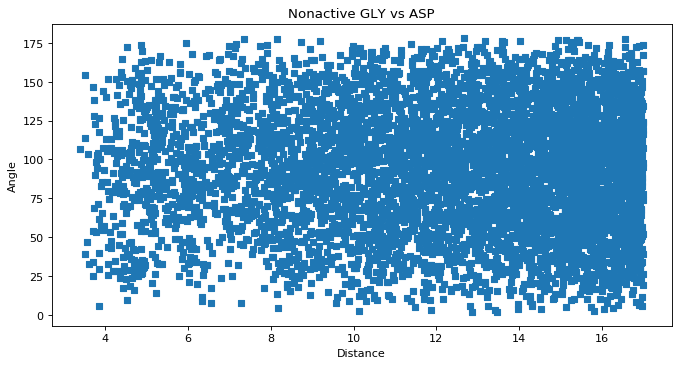

In [436]:
plt.figure(figsize = (10,5),dpi=80)

plt.scatter(coordinate1,coordinate2,
           marker = "s")


#plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])

plt.xlabel("Distance")
plt.ylabel("Angle")
plt.title("Nonactive {} vs {}".format(residue1,residue2))
plt.savefig("NonActive {} vs {}.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()


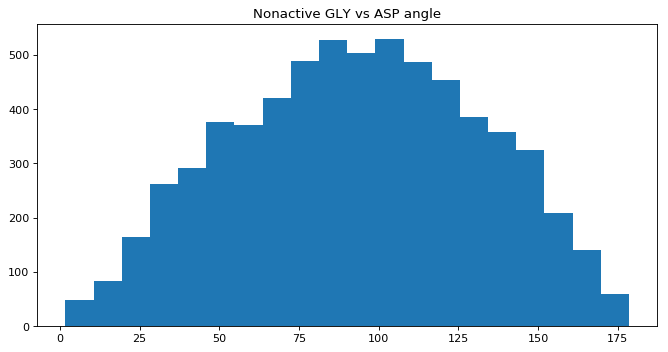

In [437]:
plt.figure(figsize = (10,5),dpi=80)
plt.hist([float(x) for x in coordinate2], bins=20)
plt.title("Nonactive {} vs {} angle".format(residue1,residue2))
plt.savefig("Nonactive {} vs {} angle.png".format(residue1,residue2),dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [411]:
combinedResult

,Seq,Residue,Center,Direction,active,all_point,PDBID,Chain
15,16,ASP,"<Vector 23.62, 84.02, 43.35>","<Vector 2.43, 0.02, -0.50>",no,None,1lam,A
57,58,HIS,"<Vector 15.20, 75.91, 19.99>","<Vector -0.44, -2.51, 1.82>",no,"26.125732528229232,105.19996336,4.807243279502...",1lam,A
59,60,ASP,"<Vector 15.93, 74.69, 15.40>","<Vector 0.50, -2.05, 1.31>",no,None,1lam,A
76,77,ASP,"<Vector 49.98, 77.01, 35.15>","<Vector 0.43, 2.03, -1.37>",no,None,1lam,A
82,83,HIS,"<Vector 46.12, 81.02, 27.26>","<Vector 2.07, -2.13, 0.90>",no,"27.821842311835272,53.8826501875,33.0438805709...",1lam,A
101,102,ASP,"<Vector 28.14, 57.32, 23.27>","<Vector -0.12, 1.39, -2.03>",no,None,1lam,A
110,111,ASP,"<Vector 29.99, 78.36, 23.55>","<Vector 0.28, -0.93, -2.32>",no,None,1lam,A
114,115,ASP,"<Vector 40.95, 80.87, 22.20>","<Vector -2.39, 0.58, -0.35>",no,None,1lam,A
130,131,ASP,"<Vector 36.87, 55.21, 11.29>","<Vector 2.07, -1.36, -0.32>",no,None,1lam,A
131,132,ASP,"<Vector 40.63, 55.34, 6.20>","<Vector -1.26, -1.91, 0.99>",no,None,1lam,A


In [10]:
allSerAndHisAndAsp = oneChain[(oneChain["Residue"] == "SER")|(oneChain["Residue"] == "HIS")|(oneChain["Residue"] == "ASP")]

In [11]:
allSerAndHisAndAsp

,Seq,Residue,Center,Direction
0,7,ASP,"<Vector 4.91, 28.58, 19.99>","<Vector 0.43, 0.22, -1.46>"
15,24,ASP,"<Vector 34.94, 28.06, -11.47>","<Vector -1.30, 1.80, 1.08>"
37,46,HIS,"<Vector 24.92, 16.64, 2.13>","<Vector 3.05, -0.02, 0.95>"
44,53,ASP,"<Vector 35.82, 29.70, -5.74>","<Vector -0.62, 0.44, 2.35>"
48,58,ASP,"<Vector 19.70, 36.26, 6.09>","<Vector 1.52, -1.03, -1.65>"
53,64,ASP,"<Vector 37.77, 28.95, 3.31>","<Vector -1.83, 1.18, 1.16>"
54,65,SER,"<Vector 38.98, 33.91, 5.44>","<Vector -0.79, -1.43, 0.99>"
55,66,ASP,"<Vector 34.50, 35.73, 6.35>","<Vector 0.56, -1.76, 1.68>"
69,80,ASP,"<Vector 33.31, 4.93, 15.93>","<Vector -1.61, 0.02, -1.85>"
71,83,SER,"<Vector 25.99, 14.08, 12.71>","<Vector 1.00, -1.14, -1.16>"


In [12]:
allSerAndHisAndAsp.is_copy = False
allSerAndHisAndAsp.loc[:,"active"] = np.where(allSerAndHisAndAsp["Seq"].isin(bindingSiteDic["2bhg"]["A"]),"yes","no")

In [13]:
allSerAndHisAndAsp

,Seq,Residue,Center,Direction,active
0,7,ASP,"<Vector 4.91, 28.58, 19.99>","<Vector 0.43, 0.22, -1.46>",no
15,24,ASP,"<Vector 34.94, 28.06, -11.47>","<Vector -1.30, 1.80, 1.08>",no
37,46,HIS,"<Vector 24.92, 16.64, 2.13>","<Vector 3.05, -0.02, 0.95>",yes
44,53,ASP,"<Vector 35.82, 29.70, -5.74>","<Vector -0.62, 0.44, 2.35>",no
48,58,ASP,"<Vector 19.70, 36.26, 6.09>","<Vector 1.52, -1.03, -1.65>",no
53,64,ASP,"<Vector 37.77, 28.95, 3.31>","<Vector -1.83, 1.18, 1.16>",no
54,65,SER,"<Vector 38.98, 33.91, 5.44>","<Vector -0.79, -1.43, 0.99>",no
55,66,ASP,"<Vector 34.50, 35.73, 6.35>","<Vector 0.56, -1.76, 1.68>",no
69,80,ASP,"<Vector 33.31, 4.93, 15.93>","<Vector -1.61, 0.02, -1.85>",no
71,83,SER,"<Vector 25.99, 14.08, 12.71>","<Vector 1.00, -1.14, -1.16>",no


#### two example plot ser 83 and 182 ser

In [14]:
HisAndAsp = allSerAndHisAndAsp[(allSerAndHisAndAsp["Residue"]=="HIS")|(allSerAndHisAndAsp["Residue"]=="ASP")]

In [15]:
HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]

0        7
15      24
44      53
48      58
53      64
55      66
69      80
85      98
92     105
109    123
124    138
151    171
154    174
Name: Seq, dtype: object

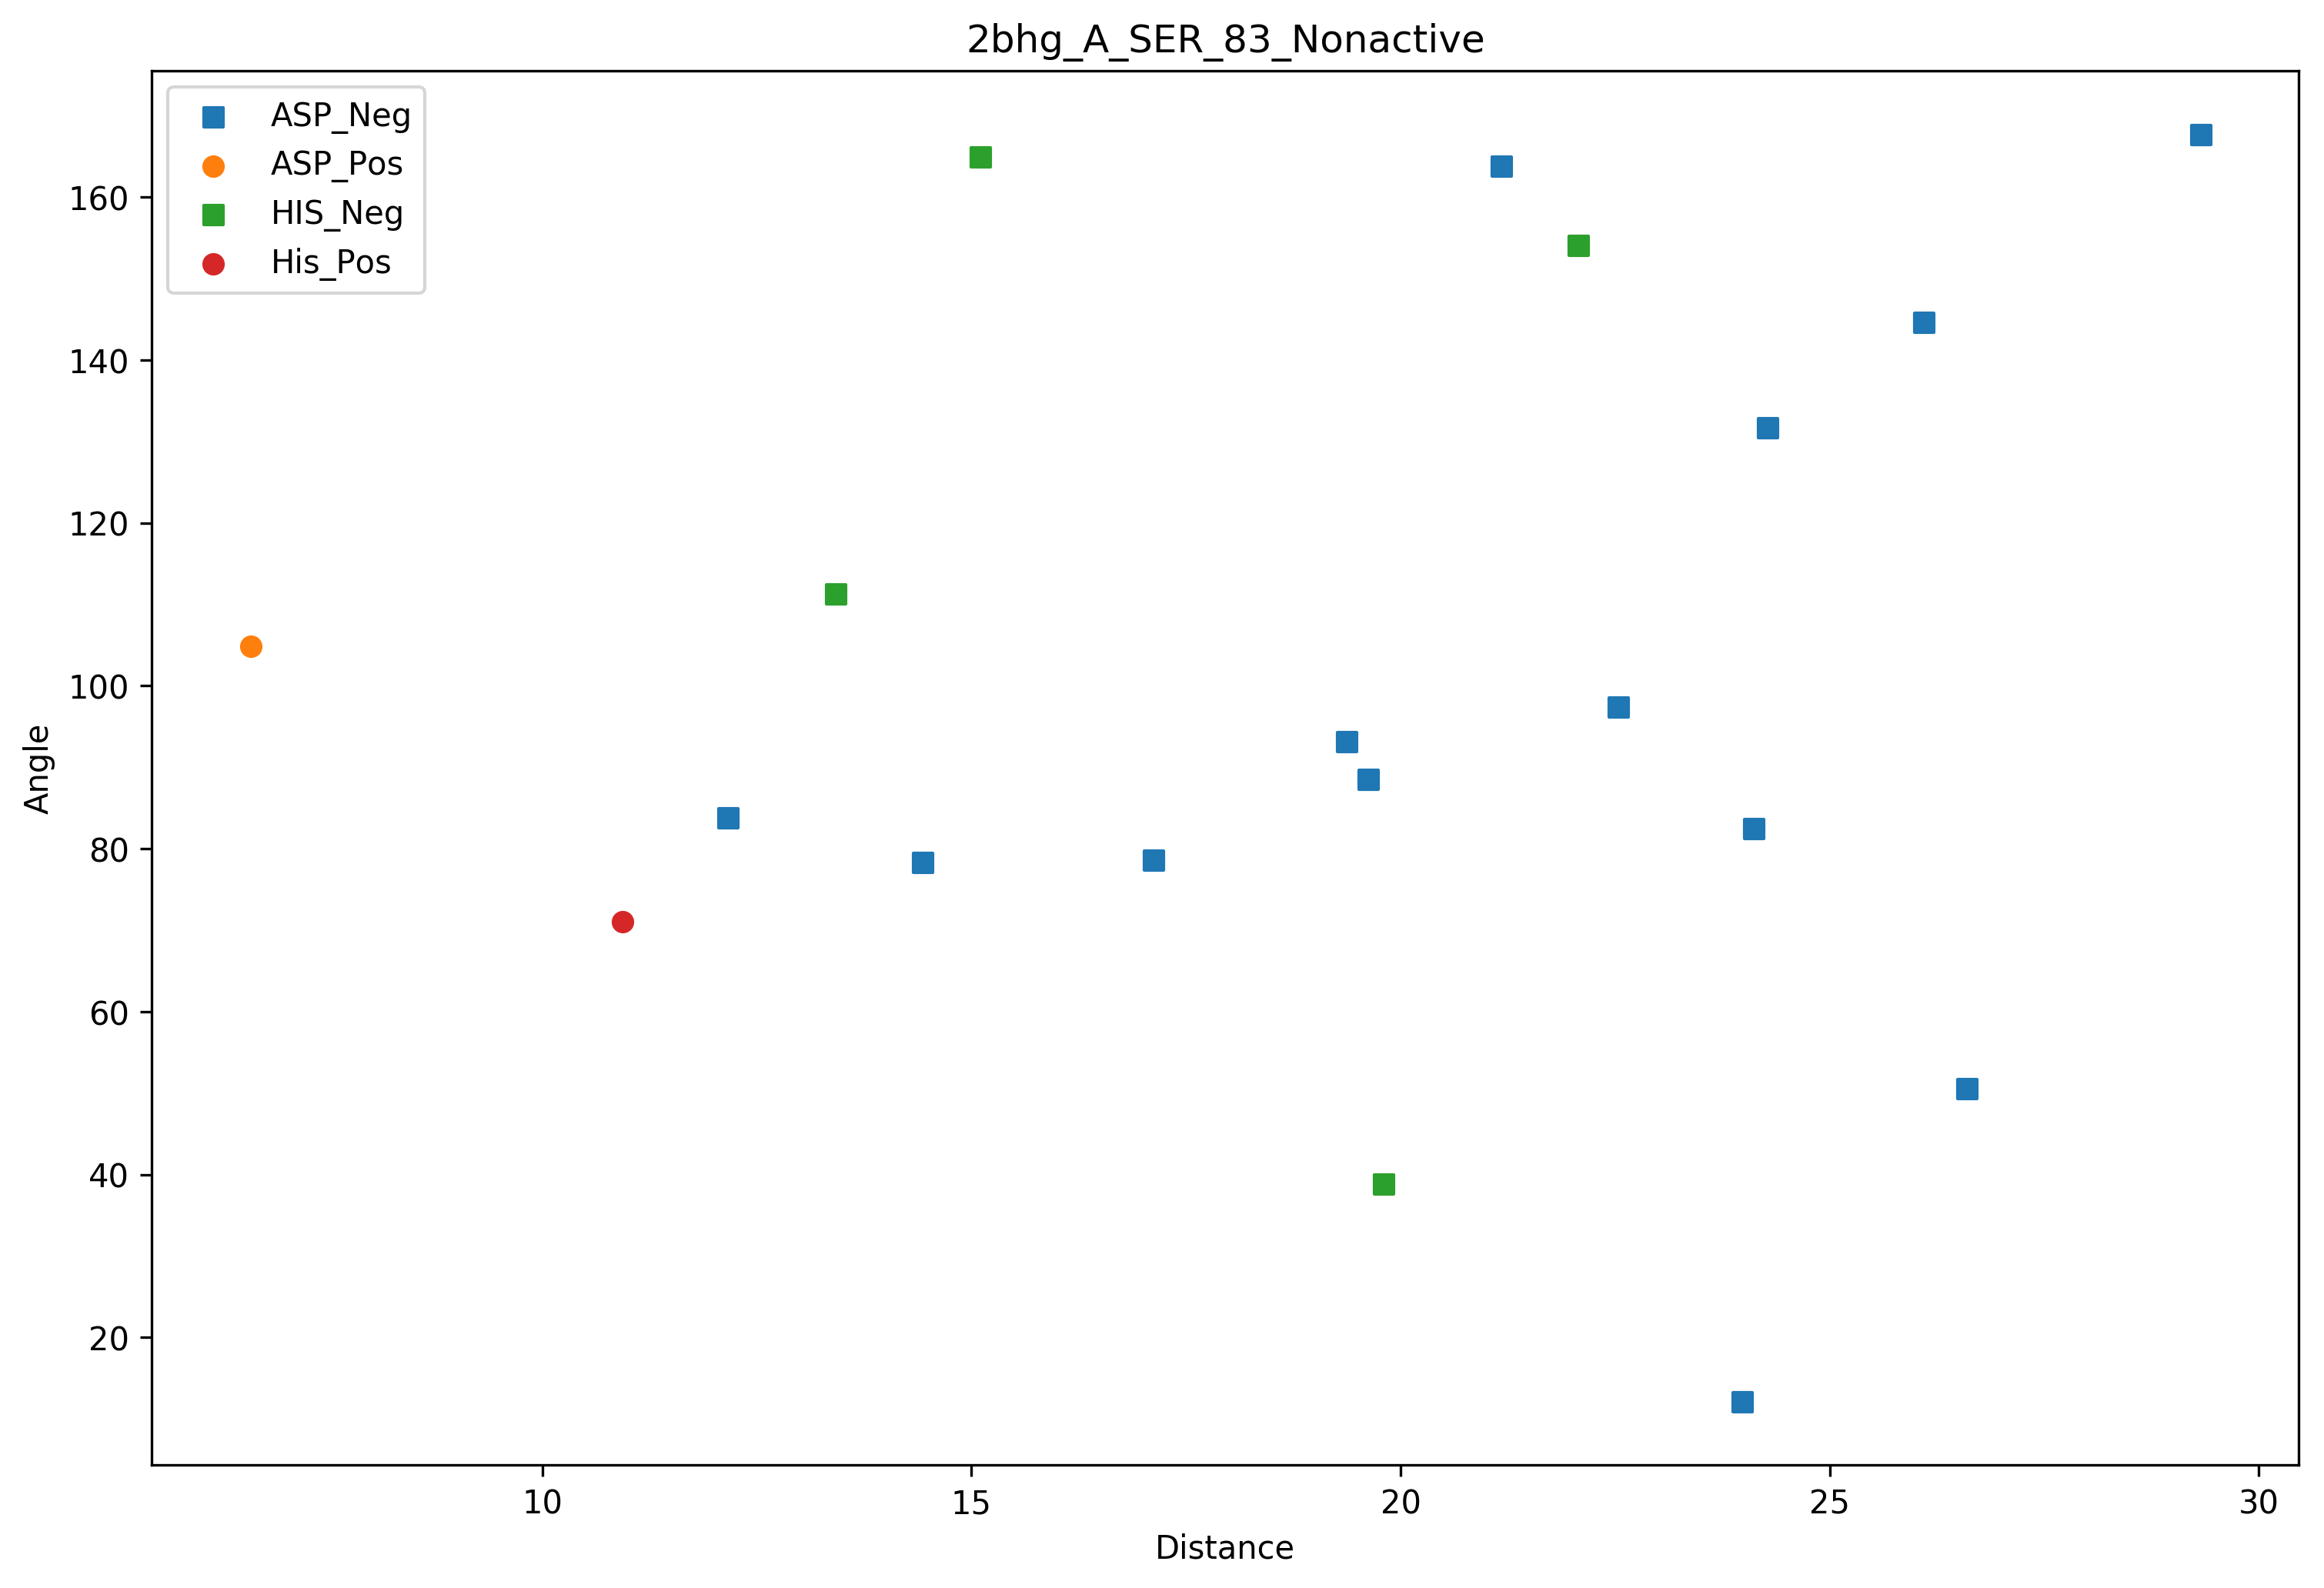

In [203]:
plt.figure(figsize = (12,8),dpi=300)

plt.scatter(distanceMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.scatter(distanceMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[83,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])
plt.xlabel("Distance")
plt.ylabel("Angle")
plt.title("2bhg_A_SER_83_Nonactive")
plt.savefig("2bhg_A_SER_83_Nonactive.png",dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()

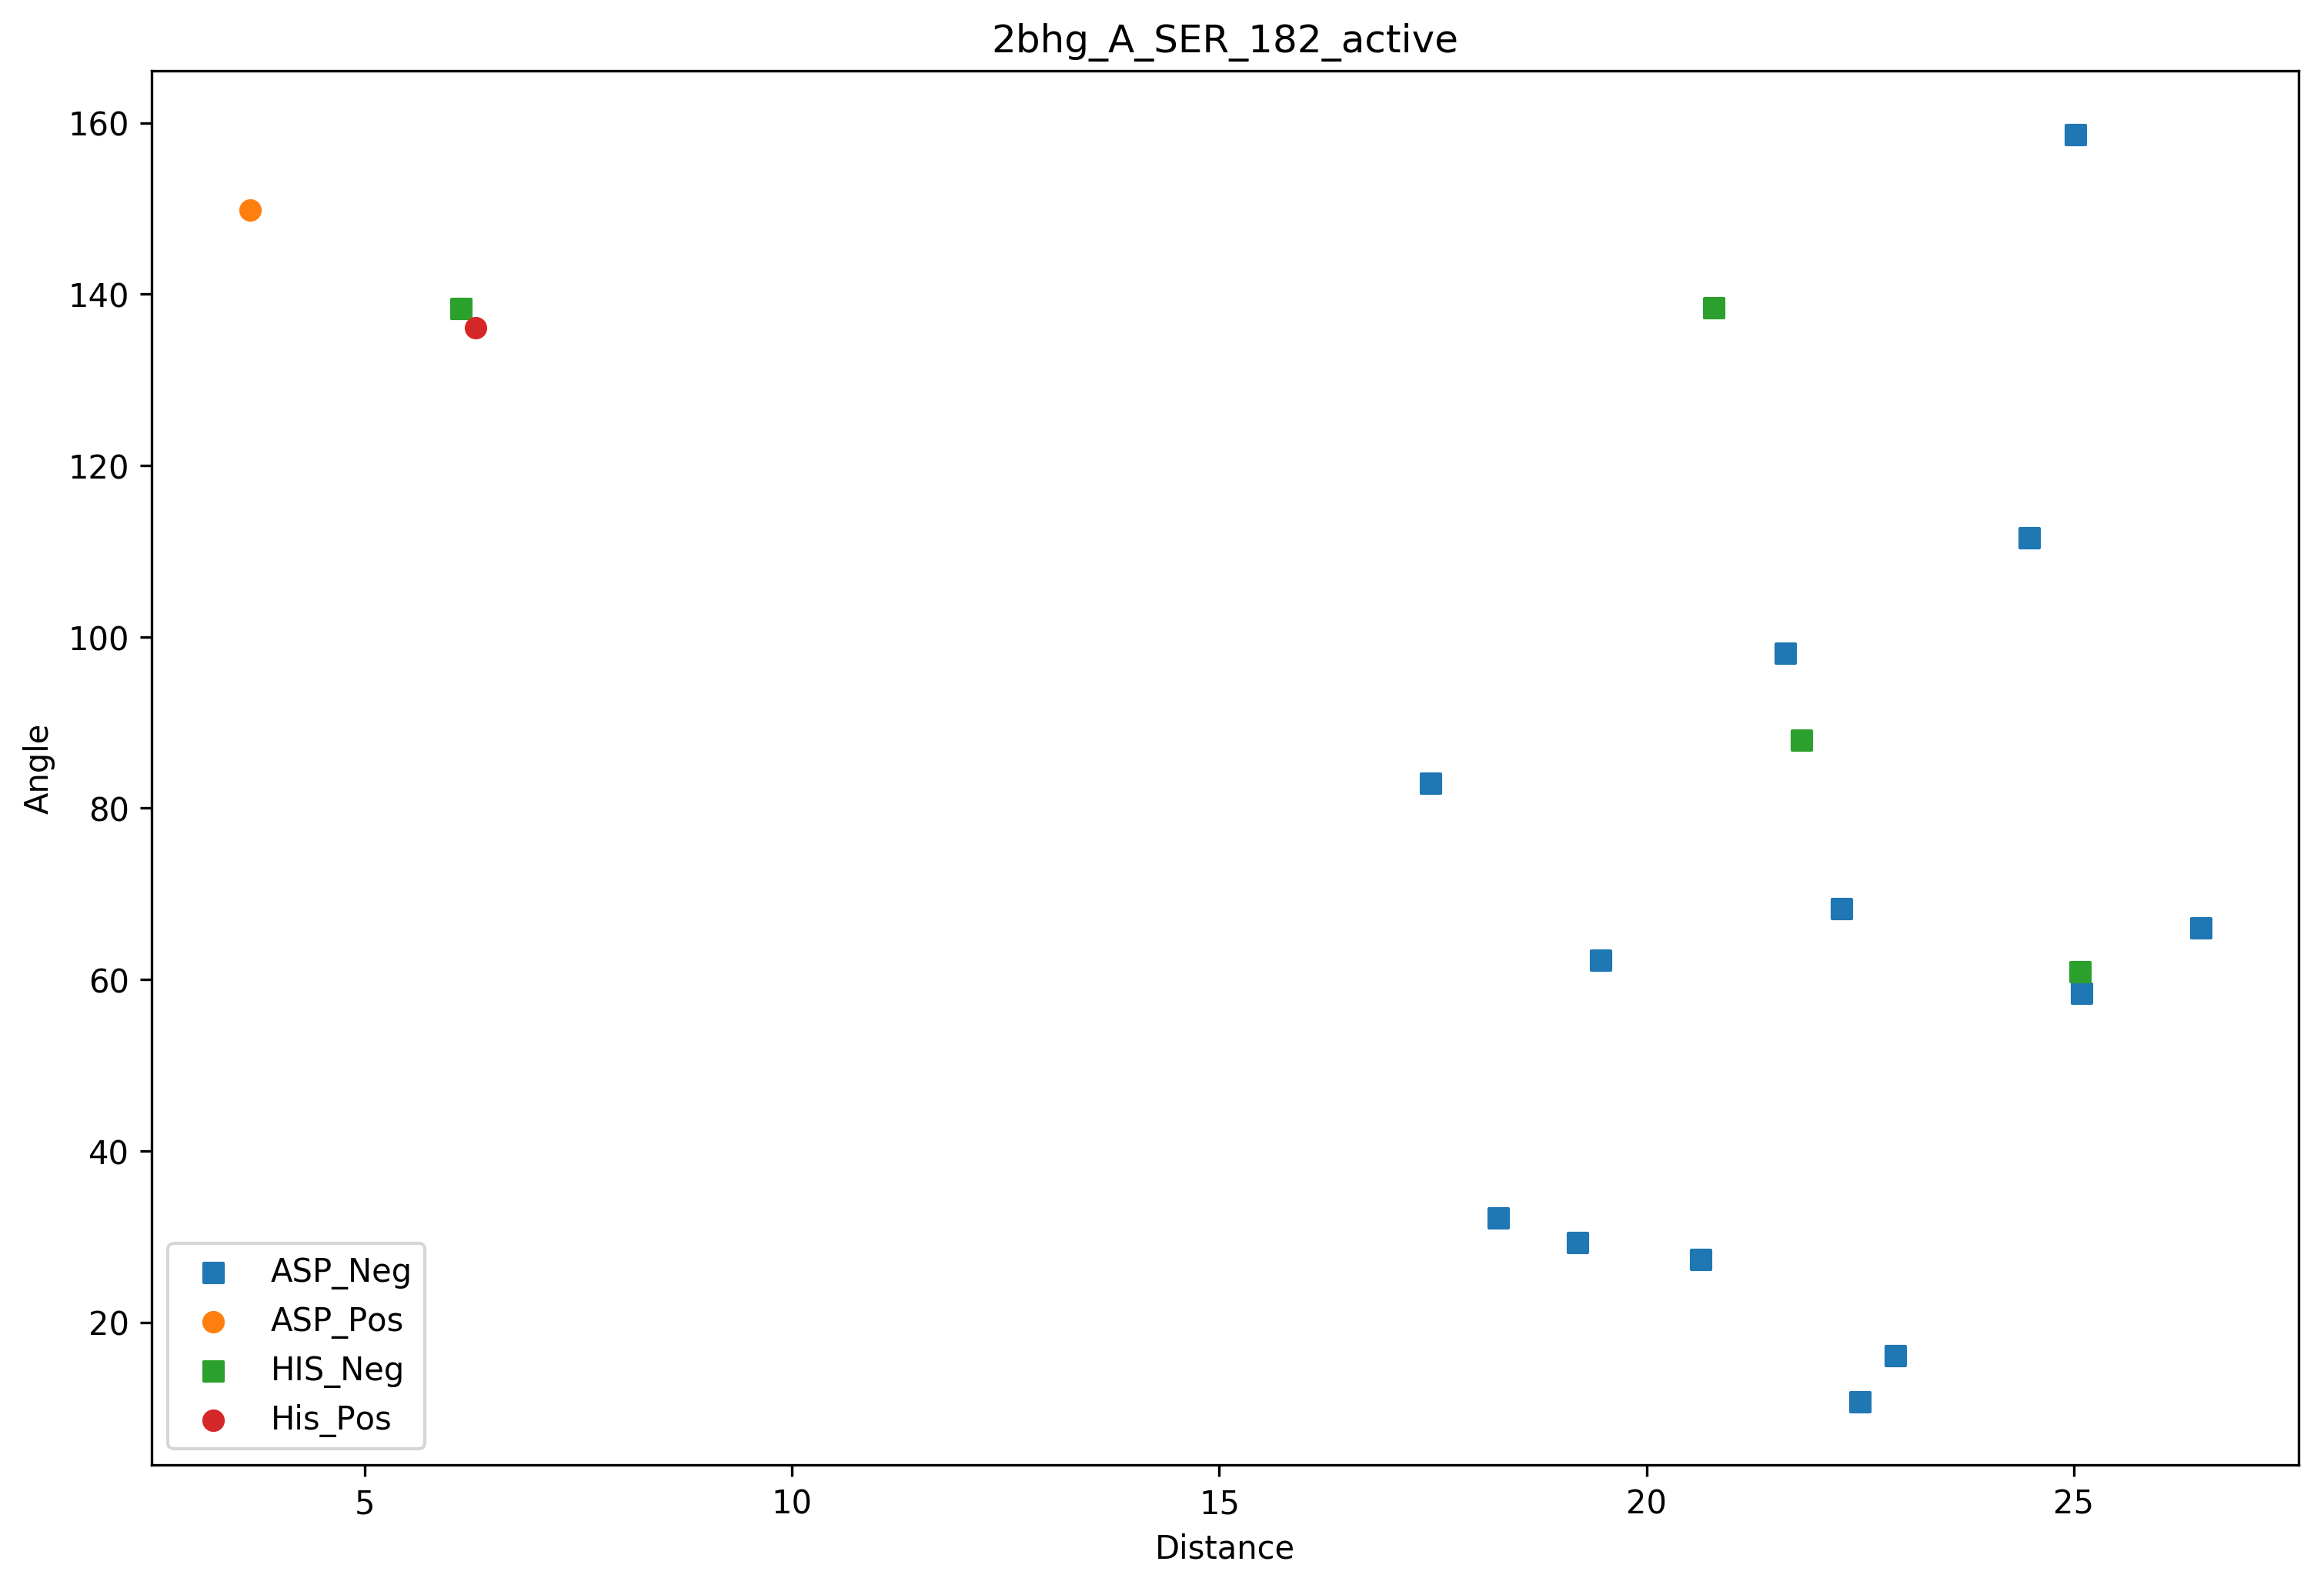

In [204]:
plt.figure(figsize = (12,8),dpi=300)

plt.scatter(distanceMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.scatter(distanceMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           angleMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="no")]["Seq"]],
           marker = "s")

plt.scatter(distanceMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]],
           angleMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="HIS")&(HisAndAsp["active"]=="yes")]["Seq"]])

plt.legend(["ASP_Neg","ASP_Pos","HIS_Neg","His_Pos"])

plt.xlabel("Distance")
plt.ylabel("Angle")
plt.title("2bhg_A_SER_182_active")

plt.savefig("2bhg_A_SER_182_active.png",dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()

In [16]:
distanceMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]]

7      25.0969
24     26.4922
53     24.4765
58     21.6274
64     22.2847
66     25.0229
80      18.263
98     22.5003
105    19.4658
123    17.4717
138    19.1918
171    20.6311
174    22.9166
Name: 182, dtype: object

In [17]:
angleMatrix.loc[182,HisAndAsp[(HisAndAsp["Residue"]=="ASP")&(HisAndAsp["active"]=="no")]["Seq"]]

7       58.422
24     66.0099
53     111.575
58     98.0933
64     68.3081
66     158.661
80     32.1407
98     10.7261
105    62.2729
123    82.9376
138     29.337
171    27.3044
174    16.0534
Name: 182, dtype: object